# Network Compression : Practical Session

Lecture slides available on https://www.robindar.com/teaching/lnr_lecture.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [3]:
largest_eigenvalue = lambda m: torch.max(torch.eig(m)[0][:,0]).item()

In [4]:
rand_matrix = lambda *size: torch.randn(size=tuple(size), dtype=torch.float64)

We generate some toy data to test our solvers, with a high precision to reduce the impact of numerical errors

In [5]:
part1_test_lam = .1  # hyperparameter to use with the test data. Don't lower it too much at first

d, h, r, n = 100, 200, 80, 10000
x = rand_matrix(d, r) @ rand_matrix(r, n)
y = rand_matrix(h, d) @ x

r_xx = (x / d) @ (x.T / n)
r_yx = (y / d) @ (x.T / n)

# Part 1 - Solving the Linear Reconstruction

Recall that the linear reconstruction problem that we wish to solve is
$\quad(\> \text{with}\> \lVert \mathbf{M} \rVert_{2,1} = \sum_j \sqrt{ \sum_i \mathbf{M}_{i,j}^2}\>)$

$$\min_\mathbf{M} \quad \mathbb{E}_{X \sim \mathcal{D}}\>\frac{1}{2} \lVert \mathbf{W} X - \mathbf{M} X \rVert^2_2 \> +\> \lambda \cdot \lVert \mathbf{M} \rVert_{2,1}$$

_Good news_ : this problem is strictly convex, therefore relatively easy to solve, and has a unique optimum.<br/>
_Bad news_ : the regularization is not differentiable near the optimum, regular gradient descent won't do.

-----

For the sake of clarity, let us distinguish two functions in this objective:
$$ f : \mathbf{M} \mapsto \mathbb{E}_X \> \frac{1}{2} \lVert \mathbf{W} X - \mathbf{M} X \rVert_2^2
\quad \text{and} \quad
g : \mathbf{M} \mapsto \lVert \mathbf{M} \rVert_{2,1} $$

$$ \mathcal{L} = f + \lambda \cdot g $$

We will switch to arbitrary output reconstruction with the change of variable $Y = \mathbf{W} X$<br/>
And adopt an empirical point of view with $\mathbf{X} \in \mathbb{R}^{d \times n}$ the concatenated samples
instead of the expectation in $X$

$$f(\mathbf{M}) = \frac{1}{2n} \operatorname{Tr}\left[(\mathbf{Y} - \mathbf{M} \mathbf{X}) (\mathbf{Y} - \mathbf{M} \mathbf{X})^T\right]$$

$f$ is differentiable, and can be written with the correlation matrices $R_{x,x} = \frac{1}{n} \mathbf{X} \mathbf{X}^T\>$ and $\> R_{y,x} = \frac{1}{n} \mathbf{Y} \mathbf{X}^T$. Derive its gradient and Hessian.

Write $f$ and its gradient as a function of those matrices. Note how the dimensions of the matrices involved
no longer depend on the number of samples $n$. This means that once the correlations are computed, we can
solve everything in memory, without IO calls to read data from disk or having to pass it through all the previous
layers (even for arbitrarily deep networks).

-----

$g$ is not differentiable. The trick we will use to optimize it is to use its associated proximal operator instead:

$$\operatorname{prox}_{\>t \cdot g} : \mathbf{M} \mapsto \operatorname{argmin}_\mathbf{U} \left( t \cdot g(\mathbf{U}) + \frac{1}{2} \lVert \mathbf{U} - \mathbf{M} \rVert^2_F \right)$$

Which in our case is given in closed form by:

$$
\forall t \in \mathbb{R}^+ \quad \left( \operatorname{prox}_{\>t \cdot g}(\mathbf{M})\right)_{i,j} =
\mathbf{M}_{i,j} \cdot \left(1 - \dfrac{t}{\sqrt{ \sum_k \mathbf{M}_{k,j}^2 }}\right)
\>\> \text{if} \>\> \sqrt{ \sum_k \mathbf{M}_{k,j}^2 } > t \>,\>\> \text{and} \>\>
0
\>\>\text{otherwise}
$$

In [6]:
# R_xx : tensor(d, d), R_yx : tensor(h, d), m : tensor(h, d)  ->  f(m) : tensor(1)
def f(r_xx, r_yx, m):
    return torch.einsum('ij,jk,ik->', m, r_xx, m) / 2 - (m * r_yx).sum()

# R_xx : tensor(d, d), R_yx : tensor(h, d), m : tensor(h, d)  ->  grad_f(m) : tensor(h, d)
def grad_f(r_xx, r_yx, m):
    return - (r_yx - m @ r_xx)

In [7]:
# R_xx : tensor(d, d), R_yx : tensor(h, d), m : tensor(h, d)  ->  g(m) : tensor(1)
def g(m):
    return (m ** 2).sum(0).sqrt().sum()

# t : float, m : tensor(h, d)  ->  prox_{tg}(m) : tensor(h, d)
def prox_g(t, m):
    colsum = (m ** 2).sum(0, keepdim=True).sqrt()
    prox_scale = torch.where(colsum > t, 1 - t / colsum, torch.zeros_like(colsum))
    return m * prox_scale

### 1.A - Slowly but surely : Forward-Backward Descent

The forward-backward algorithm (also known as "proximal gradient descent" in this particular case), is a descent method used to minimize the sum of a smooth function and simple function (i.e. prox easily computable). It gives an $\varepsilon$-approximation in $\mathcal{O}(\frac{1}{\varepsilon})$ iterations, and has the advantage of being a descent method, so mostly all stopping conditions will do the trick.

$$ M_{k+1} = \operatorname{prox}_{(\lambda / L) \,\cdot\, g} \left( M_k - \frac{1}{L} \nabla f (M_k) \right)
\quad \text{where} \>\> \nabla^2 f \preccurlyeq L $$

In [8]:
# R_xx : tensor(d, d), R_yx : tensor(h, d), lam : float, m : tensor(h, d)
#  ->  m^* : tensor(h, d), loss_hist : list(float)
def __proximal_gradient_descent(r_xx, r_yx, lam, m):
    L = largest_eigenvalue(r_xx)
    prev_m = m + float("inf")
    loss_hist = []
    while torch.norm(m - prev_m) / (torch.norm(m) + 1e-10) > 1e-8:
        loss_hist.append(f(r_xx, r_yx, m) + lam * g(m))
        prev_m, m = m, prox_g(lam / L, m - grad_f(r_xx, r_yx, m) / L)
    return m, loss_hist

def proximal_gradient_descent(r_xx, r_yx, lam):
    m0 = torch.zeros_like(r_yx)
    m, loss_hist = __proximal_gradient_descent(r_xx, r_yx, lam, m0)
    return m

tensor(-7787.8591, dtype=torch.float64)


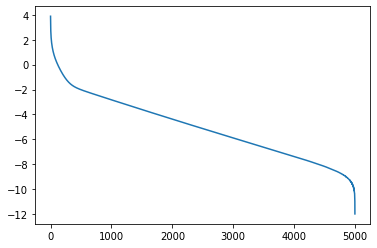

In [9]:
_, hist = __proximal_gradient_descent(r_xx, r_yx, part1_test_lam, torch.zeros_like(r_yx))
plt.plot(np.log10(np.array(hist) - np.min(hist) + 1e-12))
print(hist[-1])

### 1.B - Bouncing faster : Fast Iterative Soft-Thresholding Algorithm

"A Fast Iterative Soft-Thresholding Algorithm" [Beck & Teboulle 2009] presents a way to obtain an $\varepsilon$-approximation in only $\mathcal{O}(\frac{1}{\sqrt \varepsilon})$ iterations, by performing the gradient step with respect to a look-ahead variable ($\mathbf{A}$) instead of the current estimate of the solution ($\mathbf{M}$).

The counterpart is that this is no longer a descent method.<br/>
What would be a reasonable stopping condition for this algorithm ?
Implement it and plot $\> k \mapsto \log \left(\mathcal{L}(\mathbf{M_k}) - \mathcal{L}(\mathbf{M}^*)\right)\>$. You should see it bounce.

$$ A_k = M_k + \dfrac{k}{k + q + 1} \cdot (M_k - M_{k-1}) \quad \text{where} \>\> q \in \mathbb{R}^*_+$$

$$ M_{k+1} = \operatorname{prox}_{(\lambda / L) \,\cdot\, g} \left( A_k - \frac{1}{L} \nabla f (A_k) \right)
\quad \text{where} \>\> \nabla^2 f \preccurlyeq L $$

In [10]:
# R_xx : tensor(d, d), R_yx : tensor(h, d), lam : float, q : float, m : tensor(h, d)
#  ->  m^* : tensor(h, d), loss_hist : list(float)
def __fista(r_xx, r_yx, lam, q, m):
    L = largest_eigenvalue(r_xx)
    prev_m = m
    loss_hist = []
    k, delta = 0, 1
    while k < int(1e5) and delta > 1e-8:
        k += 1
        u = (k - 1) / (k + q + 2)
        a = m + u * (m - prev_m)
        loss_hist.append(f(r_xx, r_yx, m) + lam * g(m))
        prev_m, m = m, prox_g(lam / L, a - grad_f(r_xx, r_yx, a) / L)
        delta = .5 * delta + torch.norm(m - prev_m) / (torch.norm(m) + 1e-10)
    return m, loss_hist

def fista(r_xx, r_yx, lam, q=10):
    m0 = torch.zeros_like(r_yx)
    m, loss_hist = __fista(r_xx, r_yx, lam, q, m0)
    return m

The look-ahead distance $u$ is parameterized by a positive real value $q$. The bound on the rate of convergence
holds for all $q$, but different values will generate different behaviors. Higher values diminish
the amplitude of the bouncing effect, but slow down convergence during the first few iterations.

The ideal $q$ is hard to determine because it depends on the number of iterations that will be performed,
which depends itself on the target precision and the value of the hyperparameter chosen. Smaller values of
the hyperparameter will tend to require more iterations, which suggests we should aim for a relatively low
value of $q$, but raising it a little will have a smoothing effect that will be beneficial for our case because
it will allow the stopping condition to fire earlier when the objective reaches good precision.

Experiment with different values of $q$ to observe these behaviors.

q =  1 : tensor(-7787.8591, dtype=torch.float64)


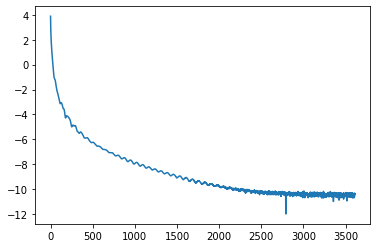

q =  5 : tensor(-7787.8591, dtype=torch.float64)


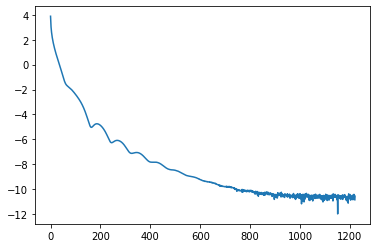

q =  50 : tensor(-7787.8591, dtype=torch.float64)


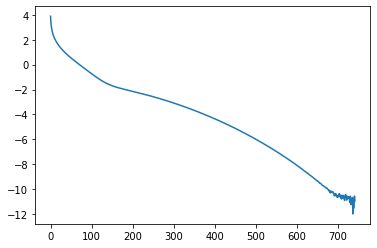

q =  250 : tensor(-7787.8591, dtype=torch.float64)


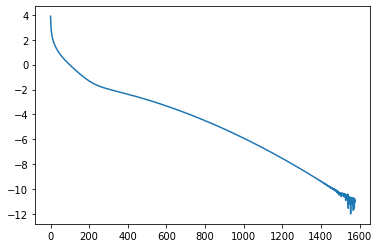

In [11]:
for q in [ 1, 5, 50, 250 ]:
    _, hist = __fista(r_xx, r_yx, part1_test_lam, q, torch.zeros_like(r_yx) + .01)
    plt.plot(np.log10(np.array(hist) - np.min(hist) + 1e-12), label=f"q = {q}")
    print("q = ", q, ":", hist[-1])
    plt.show()

### 1.C - Straight to Hell : Alternate Minimization + FISTA

The problem with FISTA is the slow movement of the estimate solution, which requires a lot of iterations
to go all the way from the initial point $\mathbf{M}_0$ to the optimal solution $\mathbf{M}^*$.
The exact convergence bound for FISTA is

$$ \mathcal{L}(\mathbf{M}_k) - \mathcal{L}(\mathbf{M}^*) \leq \dfrac{2 L}{k^2} \lVert \mathbf{M}_0 - \mathbf{M}^* \rVert_F^2 $$

If we were to give an initial point $\mathbf{M}_0$ not too far from the optimum, the convergence to the exact optimum would be very fast.

------

In order to compute such an initial point, we will use the variational expression of the $\ell_1$-norm

$$ \forall w \in \mathbb{R}, \quad |w| = \min_{\eta > 0} \frac{w^2}{2 \eta} + \frac{\eta}{2} $$

Which extends to the $\ell_{2,1}$ norm we are interested in

$$ \lVert \mathbf{M} \rVert_{2,1} = \sum_{j<d} \left| \sqrt{ \sum_{i<h} \mathbf{M}_{i,j}^2 }\right| 
= \min_{\eta \in \mathbb{R}_{*+}^d} \sum_j \frac{\sum_i \mathbf{M}_{i,j}^2 }{2 \eta_j} + \dfrac{\eta_j}{2}$$

-----

The Linear Reconstruction problem then becomes

$$ \min_{\mathbf{M}, \> \eta} \> \operatorname{Tr}\left( \> 2 R_{y,x} \mathbf{M}^T + \mathbf{M} R_{x,x} \mathbf{M}^T
+ \lambda \cdot \mathbf{M} D(\eta^{-1}) \mathbf{M}^T \> \right) + \lambda \cdot \eta^T 1 $$

To which we add a smoothing term $\varepsilon \sum_j \eta_j^{-1}$ to make the level sets with respect to $\eta$ compact on the positive orthant, which ensures alternate minimization algorithms converge [Bach et al., 2011].
Derive a closed form optimal $\eta$ for fixed $\mathbf{M}$ and vice versa, by cancelling gradients of this function.

The smoothing term induces a bias in the solution. Why is that not a problem ? What does that tell you on how to choose $\varepsilon$ ?<br/>
Would you rather spend your computation budget on alternate minimization or FISTA ? Choose a stopping condition accordingly

In [12]:
# R_xx : tensor(d, d), R_yx : tensor(h, d), lam : float, m0 : tensor(h, d)
#  ->  m : tensor(h, d), loss_hist : list(float)
def __alternate_minimization(r_xx, r_yx, lam, m):
    loss_hist = []
    for _ in range(50):
        u = ((m ** 2).sum(0) + 1e-10).sqrt()
        k = r_xx + lam * torch.diag(1 / u)
        m = torch.solve(r_yx.T, k)[0].t()
        loss_hist.append(f(r_xx, r_yx, m) + lam * g(m))
    return m, loss_hist

def alternate_minimization(r_xx, r_yx, lam, _d=10):
    m = torch.zeros_like(r_yx)
    m, _ = __alternate_minimization(r_xx, r_yx, lam, m)
    m, _ = __fista(r_xx, r_yx, lam, _d, m)
    return m

tensor(-7787.8591, dtype=torch.float64)


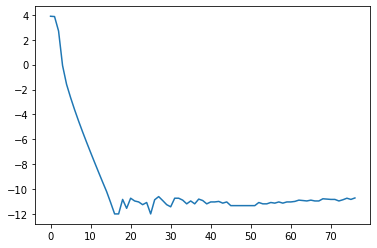

In [13]:
m = torch.zeros_like(r_yx)
m, hist1 = __alternate_minimization(r_xx, r_yx, part1_test_lam, m)
m, hist2 = __fista(r_xx, r_yx, part1_test_lam, 10, m)
hist = hist1 + hist2

plt.plot(np.log10(np.array(hist) - np.min(hist) + 1e-12))
print(f(r_xx, r_yx, m) + part1_test_lam * g(m))

## Evaluation & Checkpoint

In [14]:
# Choose your prefered method as default for the following section
DEFAULT_METHOD = 'alternate_minimization'

def solve_linear_reconstruction(r_xx, r_yx, lam, method=DEFAULT_METHOD):
    try:
        return {
            'proximal_gradient_descent': proximal_gradient_descent,
            'fista': fista,
            'alternate_minimization': alternate_minimization,
        }[method](r_xx, r_yx, lam)
    except KeyError:
        raise ValueError(f"No such method for linear reconstruction: '{method}'")

In [15]:
d, r, h, n = 500, 450, 200, 60000
x = rand_matrix(d, r) @ rand_matrix(r, n)
y = rand_matrix(h, d) @ x

r_xx = (x / d) @ (x.T / n)
r_yx = (y / d) @ (x.T / n)

# %timeit -r5 solve_linear_reconstruction(r_xx, r_yx, .1, 'proximal_gradient_descent')  # maybe don't
%timeit -r5 solve_linear_reconstruction(r_xx, r_yx, .1, 'fista')
%timeit -r5 solve_linear_reconstruction(r_xx, r_yx, .1, 'alternate_minimization')

4.39 s ± 41.6 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
672 ms ± 5.21 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


# Part 2 - Network compression via linear activation reconstruction

### Setup and boilerplate code

This is just the setup for training and testing an MNIST model.
You probably have done this often enough by now to be able to write it on your own, but this is not
the focus of this practical session.

In [16]:
normalizer = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,)) ])
mnist_get = lambda train: datasets.MNIST('data', train=train, download=True, transform=normalizer)
mnist_train, mnist_test = mnist_get(train=True), mnist_get(train=False)

In [17]:
device = 'cpu'  # change to 'cuda:0' if you have a GPU, or whatever your processing unit is named
dataloader_settings = { 'batch_size': 256, 'shuffle': True }

In [18]:
def dataset_iterator(dataset, model, action):
    action_results = []
    for data, target in torch.utils.data.DataLoader(dataset, **dataloader_settings):
        data, target = data.to(device), target.to(device)
        action_results.append(action(model(data), target))
    return action_results

In [19]:
def count_correct(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(target.view_as(pred)).sum().item()
    return correct
    
def gradient_step(optimizer, output, target):
    F.cross_entropy(output, target).backward()
    optimizer.step(); optimizer.zero_grad()
    return count_correct(output, target)

def train(model, optimizer):
    iter_step = lambda out, target: gradient_step(optimizer, out, target)
    correct_counts = dataset_iterator(mnist_train, model, iter_step)
    return sum(correct_counts) / len(mnist_train)

test = lambda model: sum(dataset_iterator(mnist_test, model, count_correct)) / len(mnist_test)

### MNIST Model : LeNet-5 [LeCun et al., 1998] - (Caffe flavor)

The LeNet-5 model was introduced by Yann Le Cun in 1998, and achieves easily 99% accuracy on MNIST.<br/>
We will be using the version provided in the Caffe framework, which has more parameters but is faster to train.

Additionally, we will need to extract outputs after a specific layer for our reconstructions,
which is why we use this odd definition instead of just a `torch.nn.Sequential` construction.

In [20]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 5)
        self.conv2 = torch.nn.Conv2d(20, 50, 5)
        self.fc1 = torch.nn.Linear(800, 500)
        self.fc2 = torch.nn.Linear(500, 10)
        self.layers = [ self.conv1, self.conv2, self.fc1, self.fc2 ]
        self.layer_forward = [
            lambda x: F.relu(F.max_pool2d(self.conv1(x), 2)),
            lambda x: F.relu(F.max_pool2d(self.conv2(x), 2)).view(x.size(0), -1),
            lambda x: F.relu(self.fc1(x)),
            lambda x: self.fc2(x),
        ]
    
    def forward(self, x, steps=4):
        for i in range(steps):
            x = self.layer_forward[i](x)
        return x

model = LeNet5()

In [21]:
PATH = "lenet5_trained"

def save_lenet(model):
    torch.save(model.state_dict(), PATH)

def load_lenet():
    model = LeNet5()
    model.load_state_dict(torch.load(PATH))
    return model.eval()

In [22]:
model.train(); model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for i in range(8):
    acc = train(model, optimizer)
    print(f"Epoch {i:2d} - train accuracy: {acc:.4f}")
save_lenet(model)

Epoch  0 - train accuracy: 0.9392
Epoch  1 - train accuracy: 0.9840
Epoch  2 - train accuracy: 0.9891
Epoch  3 - train accuracy: 0.9913
Epoch  4 - train accuracy: 0.9934
Epoch  5 - train accuracy: 0.9942
Epoch  6 - train accuracy: 0.9960
Epoch  7 - train accuracy: 0.9969


In [23]:
model.eval()  # No need to compute gradients from now on
print(f"Test accuracy: {test(model):.4f}")

Test accuracy: 0.9907


### Single Layer Compression

Now to the real compression.

We start by performing one pass over the dataset to get the correlation matrices for the
layer that we are targeting.

You may have noticed that we ignored the layer bias in our reconstruction formulation.
For now, you can ignore it as well, and just leave it with the same value. We will tackle this later on.

In [24]:
# dataset, model : LeNet5, target_layer_idx : int  ->  R_xx : tensor(d, d), R_yx : tensor(h, d)
def gather_correlations(dataset, model, target_layer_idx):
    r_xx, r_yx = 0, 0
    w = model.layers[target_layer_idx].weight
    d, n = w.size(1), len(dataset)
    for data, target in torch.utils.data.DataLoader(dataset, **dataloader_settings):
        data, target = data.to(device), target.to(device)
        data = model(data, steps=target_layer_idx).T
        r_xx += (data / d) @ (data.T / n)
        r_yx += (w @ data / d) @ (data.T / n)
    return r_xx, r_yx

In [25]:
r_xx, r_yx = gather_correlations(mnist_train, model, target_layer_idx=3)

Now use `solve_linear_reconstruction` to get the compressed weight, with $\lambda = .01$, and print the number of non-zero weights kept.

In [26]:
m = solve_linear_reconstruction(r_xx, r_yx, .01)
print(f"Proportion of weights kept : {((m ** 2).sum(0) > 0).float().mean().item():.4f}")

Proportion of weights kept : 0.1120


Let's see what accuracy we get for this compression rate. Note that the size of the weight doesn't change yet.

In [27]:
with torch.no_grad():
    model.fc2.weight = torch.nn.Parameter(m.to(dtype=model.fc2.weight.dtype))
print(f"Test accuracy: {test(model):.4f}")

Test accuracy: 0.9721


We can now perform the operation that justified the usage of this reconstruction in the first place:
commutation of the feature extractor and non-linearity, to collapse with the previous layer (fc1), which is
dense and will have some rows removed thanks to our parameter reduction on layer fc2.

Don't forget to also collapse the bias of fc1.

In [28]:
def set_weight(layer, new_weight, bias=None):
    param_like = lambda ow, nw: torch.nn.Parameter(nw.to(dtype=ow.dtype, device=ow.device))
    with torch.no_grad():
        layer.weight = param_like(layer.weight, new_weight)
        if bias is not None:
            layer.bias = param_like(layer.bias, bias)

In [29]:
# keep : tensor<boolean>(d)
keep = (m ** 2).sum(0) > 0

set_weight(model.fc2, m[:,keep])
set_weight(model.fc1, model.fc1.weight[keep,:], model.fc1.bias[keep])

print(f"Test accuracy: {test(model):.4f}")

Test accuracy: 0.9721


Check that you get the same accuracy as before the weight collapse.

## Improving peformance

### Lasso debiasing

You should already have a massive weight reduction on the last layer with a reasonably small drop in accuracy.
But you might have noticed that we ignored a very important issue in the formulation of our problem : the $\ell_1$ norm.

Penalizing the norm of columns allows us to control the tradeoff between having more columns and matching more closely
the data, versus having better compression but increasing the reconstruction error. Higher values of $\lambda$
drive the norm of the columns down, some even reach zero, and that is how we choose which columns to remove.

But now that we have chosen which columns to remove, there is no need for the remaining to have a small norm,
we can release that constraint to match the data more accurately with the columns we chose.

Note: we call that step "debiasing", because it tries to remove the bias toward matrices with small weights that our
choice of $\ell_1$ introduced, but it does not actually remove the bias, it's only a trick to limit its effect in practice

In [30]:
# R_xx : tensor(d, d), R_yx : tensor(h, d), keep : tensor<boolean>(d)  ->  m : tensor(h, d)
def debias(r_xx, r_yx, keep):
    return torch.solve(r_yx.T[keep,:], r_xx[keep,:][:,keep])[0].T

# model : LeNet5, target_idx : int, lam : float  ->  compressed_model : LeNet5
def compress_layer(model, target_idx, lam):
    r_xx, r_yx = gather_correlations(mnist_train, model, target_idx)
    m = solve_linear_reconstruction(r_xx, r_yx, lam)
    keep = (m ** 2).sum(0) > 0
    m = debias(r_xx, r_yx, keep)
    set_weight(model.fc2, m)
    set_weight(model.fc1, model.fc1.weight[keep,:], model.fc1.bias[keep])
    return model

Now use your compression pipeline and check that your get better results than without debiasing

In [31]:
# WARNING: Jupyter is full of memory leaks, deleting variables is important
# We need to get rid of variables we don't need early so we don't crash the kernel
del m, keep, r_xx, r_yx

In [32]:
model = load_lenet()
model = compress_layer(model, target_idx=3, lam=.01)

print(f"Test accuracy: {test(model):.4f}")

Test accuracy: 0.9881


## Evaluating performance

Our compression of the last layer went great so far, but how much did we compress the full network ?

In [33]:
# model : LeNet5  ->  weight_count : int
def count_weights(model):
    return sum([ l.weight.numel() + l.bias.numel() for l in model.layers ])

In [34]:
compress_rate = count_weights(model) / count_weights(LeNet5())
print(f"Full model compression rate: {100*compress_rate:.2f} %")

Full model compression rate: 16.47 %


Not bad already. How do we go further down ? Where is the mass located in our network ?

In [35]:
# model : LeNet5  ->  mass_distrib : list(float)
def mass_distribution(model):
    total = count_weights(model)
    return [ (l.weight.numel() + l.bias.numel()) / total for l in model.layers ]

In [36]:
print("Mass distribution: ", [ np.round(d, 4) for d in mass_distribution(model) ])

Mass distribution:  [0.0073, 0.3528, 0.6318, 0.008]


The relative mass of the last layer is very small: concentrating our efforts on it would be pointless.
Clearly, to compress the model further, we need to be able to compress convolutional layers.
If you have enough time (and motivation) left, you can try to tackle both bias handling and convolutional kernels
in the following section, by replacing the $\ell_{2,1}$ regularization by a group lasso on the convolutional filters.

- difficulty "easy" : handle bias in layer fc2 &emsp; [default, detailled below]
- difficulty "medium" : handle linear layer after a convolution (fc1)
- difficulty "hard" : handle both convolutional layers and linear layers

### Handling bias

We ignored the bias so far, because it made things much easier, but allowing the bias to change
might allow us to reach higher accuracies for the same compression rate.

We can handle bias by simply adding a 1 to the input and reuse most of our methods.
However, biases are a little different from the other weights : we don't care about removing
the bias, so we don't need to penalize it. This means we need to re-write
- the correlation computation to add a bias
- $g$ and $\operatorname{prox}_g$ to ignore the bias in the regularization
- the alternate minimization to handle $\eta$ differently for the bias

Re-write these methods to handle biases (you should be able to copy-paste your previous code and change only ~5 lines)

In [37]:
def gather_correlations(dataset, model, target_layer_idx):
    r_xx, r_yx = 0, 0
    layer = model.layers[target_layer_idx]
    w = torch.cat([ layer.weight, layer.bias[:,None] ], dim=1)
    d, n = w.size(1), len(dataset)
    for data, target in torch.utils.data.DataLoader(dataset, **dataloader_settings):
        data, target = data.to(device), target.to(device)
        data = model(data, steps=target_layer_idx).T
        data = torch.cat([ data, torch.ones_like(data[[0]]) ], dim=0)
        r_xx += (data / d) @ (data.T / n)
        r_yx += (w @ data / d) @ (data.T / n)
    return r_xx, r_yx

def g(m):
    return (m[:,:-1] ** 2).sum(0).sqrt().sum().item()

def prox_g(t, m):
    colsum = (m ** 2).sum(0, keepdim=True).sqrt()
    prox_scale = torch.where(colsum > t, 1 - t / colsum, torch.zeros_like(colsum))
    prox_scale[:,-1] = 1
    return m * prox_scale

def __alternate_minimization(r_xx, r_yx, lam, m):
    loss_hist = []
    for _ in range(50):
        u = ((m ** 2).sum(0) + 1e-10).sqrt()
        u[-1] = float("inf")
        k = r_xx + lam * torch.diag(1 / u)
        m = torch.solve(r_yx.T, k)[0].t()
        loss_hist.append((f(r_xx, r_yx, m) + lam * g(m)).item())
    return m, loss_hist

def compress_layer(model, target_idx, lam):
    r_xx, r_yx = gather_correlations(mnist_train, model, target_idx)
    m = solve_linear_reconstruction(r_xx, r_yx, lam)
    keep = (m ** 2).sum(0) > 0
    keep[-1] = True
    m = debias(r_xx, r_yx, keep)
    set_weight(model.fc2, m[:,:-1], m[:,-1])
    set_weight(model.fc1, model.fc1.weight[keep[:-1],:], model.fc1.bias[keep[:-1]])
    return model

WARNING: the interpretation of the following result is not obvious, because reconstructing with a varying bias is
a lot easier than reconstructing with a fixed bias. Don't forget to compare compress rates, and see next section.

In [38]:
model = load_lenet()
model = compress_layer(model, target_idx=3, lam=.01)

print(f"Test accuracy: {test(model):.4f}")

compress_rate = count_weights(model) / count_weights(LeNet5())
print(f"Full model compression rate: {100*compress_rate:.2f} %")

Test accuracy: 0.9875
Full model compression rate: 15.90 %


## Fair performance evaluation

The result obtained in the cell above is confusing : both the compression rate and the accuracy changed.
What is better, more compression and lower accuracy, or the other way around ?
This is clearly application-dependant.

There is a major problem in the performance evaluation : the **tradeoff between compression and accuracy**.
We cannot use a single number to measure the quality of our compression.
We can only compare two compressions that give either the same accuracy or the
same compression rate, otherwise the conclusion is difficult to infer. The best way to get a feeling of
performance is thus to draw the Pareto frontier of this method.

Plot the accuracy versus compress rate for a wide range of the hyperparmeter.
Additionally, you can plot the same with a one-epoch retraining, to see how fast the
accuracy is recovered in this setting. Also, don't forget to handle the case where the compressed matrix is all zeros

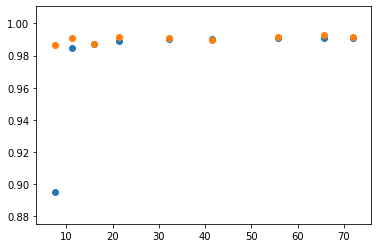

In [39]:
def quality(model, lam, retrain=False):
    model = compress_layer(model, target_idx=3, lam=lam)
    compress_rate = count_weights(model) / count_weights(LeNet5())
    if model.fc2.weight.numel() == 0:
        return (100 * compress_rate, 0)
    if retrain:
        train(model, torch.optim.Adam(model.parameters(), lr=1e-3))
    return (100 * compress_rate, test(model))

candidate_lambdas = 10 ** np.linspace(-4, -1, 10)
for retrain in [ False, True ]:
    results = [ quality(load_lenet(), lam, retrain) for lam in candidate_lambdas ]
    plt.scatter([ c for c,a in results if a > 0 ], [ a for _, a in results if a > 0 ])